# Spectra for Neutral AWAKEN case

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
for x in amrwindfedirs: sys.path.insert(1, x+'/utilities')    

import postproamrwindsample_xarray as ppsamplexr
import windspectra

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import os.path
import re
from matplotlib.lines import Line2D

import amrwind_frontend  as amrwind

%matplotlib inline

In [2]:
amrdir = '/gpfs/drhouck/AWAKEN/JRSE_Precursor/newmesh/z0_0p03-at/post_processing'
ncfile = 'sampling_80000.nc'  # netcdf filename
ablstats = 'abl_statistics80000.nc'

In [3]:
def avgSpectraNCfile(ncfilename, ptlist, group, timeindices, avgbins=[], verbose=True):
    # Initialize dicts
    Suu_avg=None
    Svv_avg=None
    Sww_avg=None
    avgUlong=None
    all_ulongavgs = []
    # First extract all of the data from the netcdf file
    db = ppsamplexr.getPlanePtsXR(ncfilename, timeindices, ptlist, groupname=group, verbose=verbose, gettimes=True)
    t  = np.array(db['times'])
    for ipt, pt in enumerate(ptlist):
        u = np.array(db[pt]['velocityx'])
        v = np.array(db[pt]['velocityy'])
        w = np.array(db[pt]['velocityz'])
        ulong, ulat = windspectra.convertUxytoLongLat(u,v)
        all_ulongavgs.append(np.mean(ulong))
        f, Suu      = windspectra.avgWindSpectra(t, ulong, avgbins)
        f, Svv      = windspectra.avgWindSpectra(t, ulat,  avgbins)
        f, Sww      = windspectra.avgWindSpectra(t, w,     avgbins)        
        if ipt == 0:
            lent    = len(t)
            favg    = f
            Suu_avg = Suu
            Svv_avg = Svv
            Sww_avg = Sww
        else:
            Suu_avg = Suu_avg + Suu
            Svv_avg = Svv_avg + Svv
            Sww_avg = Sww_avg + Sww    
    Npts = len(ptlist)
    Suu_avg = Suu_avg/Npts
    Svv_avg = Svv_avg/Npts
    Sww_avg = Sww_avg/Npts
    return favg, Suu_avg, Svv_avg, Sww_avg, np.mean(all_ulongavgs)


In [4]:
ipts = [0, 10, 20, 30, 40, 50]
jpts = [0, 10, 20, 30, 40, 50]
kpt  = 0
ptlist = []
for i in ipts:
    for j in jpts:
        ptlist.append((kpt, j, i))
        
timeindices=list(range(20000))[::10]
#timeindices=list(range(20000))[::50]
grouplist = [{'name':'p_bot', 'z':90-127*0.5},
             {'name':'p_hub', 'z':90},
             {'name':'p_top', 'z':90+127*0.5},
            ]
#group='p_hub'

In [5]:
favg = {}
Suu_avg = {}
Svv_avg = {}
Sww_avg = {}
avgUlong = {}
for group in grouplist:
    name = group['name']
    print(name)
    favg[name], Suu_avg[name], Svv_avg[name], Sww_avg[name], avgUlong[name] = avgSpectraNCfile(amrdir+'/'+ncfile, ptlist, name, 
                                                                                               timeindices, avgbins=[], verbose=True)
    print()

p_bot
[============================================================] 100.0% 
p_hub
[============================================================] 100.0% 
p_top
[============================================================] 100.0% 


## Load Kaimal data

In [6]:
case = amrwind.MyApp.init_nogui()

In [7]:
case.ABLpostpro_loadnetcdffile(amrdir+'/'+ablstats)

Loading /gpfs/drhouck/AWAKEN/JRSE_Precursor/newmesh/z0_0p03-at/post_processing/abl_statistics80000.nc
Time range: 20000.250000 to 25000.000000
Done.


In [8]:
zheights = [g['z'] for g in grouplist]
ablreport=case.ABLpostpro_printreport(avgt=[20000, 25000], avgz=zheights)

Loading u'u'_r
Loading w'w'_r
Loading theta
Loading v
Loading w'theta'_r
Loading u
Loading v'v'_r
Rotor span not specified. Fitting alpha over entire vertical domain
Rotor span not specified. Fitting veer over entire vertical domain
        z       Uhoriz      WindDir       TI_TKE     TI_horiz        Alpha    Alpha-Fit     ObukhovL         Veer     Veer-Fit 
      ===         ====         ====         ====         ====         ====         ====         ====         ====         ==== 
    26.50 5.323903e+00 2.685117e+02 8.520305e-02 1.415833e-01 1.374675e-01 1.608985e-01 1.628655e+05 2.695410e-02 2.107706e-02 
    90.00 6.264782e+00 2.700006e+02 6.261624e-02 9.739703e-02 1.121706e-01 1.608985e-01 3.865131e+04 1.855527e-02 2.107706e-02 
   153.50 6.694283e+00 2.710819e+02 5.393951e-02 8.289388e-02 1.313620e-01 1.608985e-01 2.242668e+04 1.598644e-02 2.107706e-02 

ustar: 0.289809


In [9]:
Suu_Kai = {}
Svv_Kai = {}
Sww_Kai = {}

utau   = ablreport['ustar'] #0.289809

for group in grouplist:
    z = group['z']
    name = group['name']
    Suu_Kai[name] = windspectra.getKaimal(favg[name], z, avgUlong[name])
    Svv_Kai[name] = windspectra.getKaimal(favg[name], z, avgUlong[name], params=windspectra.vKaimalconst)
    Sww_Kai[name] = windspectra.getKaimal(favg[name], z, avgUlong[name], params=windspectra.wKaimalconst)

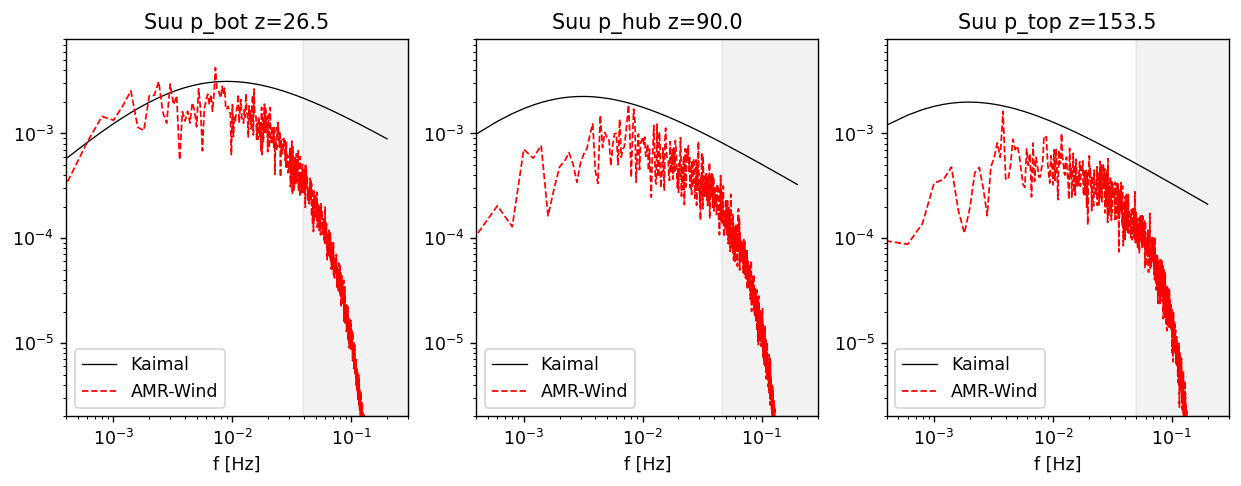

In [14]:
fig, axs = plt.subplots(1,len(grouplist), figsize=(4*len(grouplist),4), dpi=125)
nband=3
dx=10

for igroup, group in enumerate(grouplist):
    name = group['name']
    z    = group['z']
    U    = avgUlong[name]
    f, Suu = windspectra.NarrowToOctaveBand(favg[name], Suu_avg[name], nband)
    ax = axs[igroup]
    ax.loglog(favg[name], utau**2*Suu_Kai[name]/avgUlong[name]**2, '-', color='k', lw=0.75, label='Kaimal')
    ax.loglog(favg[name], favg[name]*Suu_avg[name]/U**2, '--', linewidth=1, color='r', label='AMR-Wind')
    
    ax.set_ylim([2E-6, 8E-3]);
    ax.set_xlim([4E-4, 0.3]);
    ax.set_title('Suu %s z=%0.1f'%(name, z))
    ax.set_xlabel('f [Hz]')
    
    fmax=0.6*U/(8.0*dx)
    ax.axvspan(fmax, 10, alpha=0.1, color='gray')
    ax.legend()

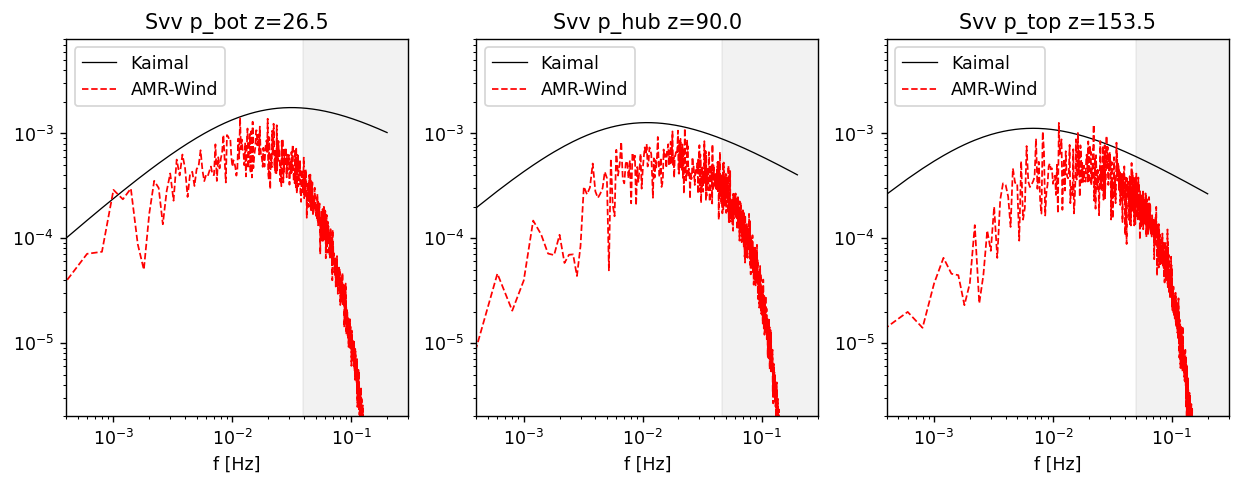

In [13]:
fig, axs = plt.subplots(1,len(grouplist), figsize=(4*len(grouplist),4), dpi=125)
nband=3
dx=10

for igroup, group in enumerate(grouplist):
    name = group['name']
    z    = group['z']
    U    = avgUlong[name]
    f, Svv = windspectra.NarrowToOctaveBand(favg[name], Svv_avg[name], nband)
    ax = axs[igroup]
    ax.loglog(favg[name], utau**2*Svv_Kai[name]/avgUlong[name]**2, '-', color='k', lw=0.75, label='Kaimal')
    ax.loglog(favg[name], favg[name]*Svv_avg[name]/U**2, '--', linewidth=1, color='r', label='AMR-Wind')
    
    ax.set_ylim([2E-6, 8E-3]);
    ax.set_xlim([4E-4, 0.3]);
    ax.set_title('Svv %s z=%0.1f'%(name, z))
    ax.set_xlabel('f [Hz]')
    
    fmax=0.6*U/(8.0*dx)
    ax.axvspan(fmax, 10, alpha=0.1, color='gray')
    ax.legend()

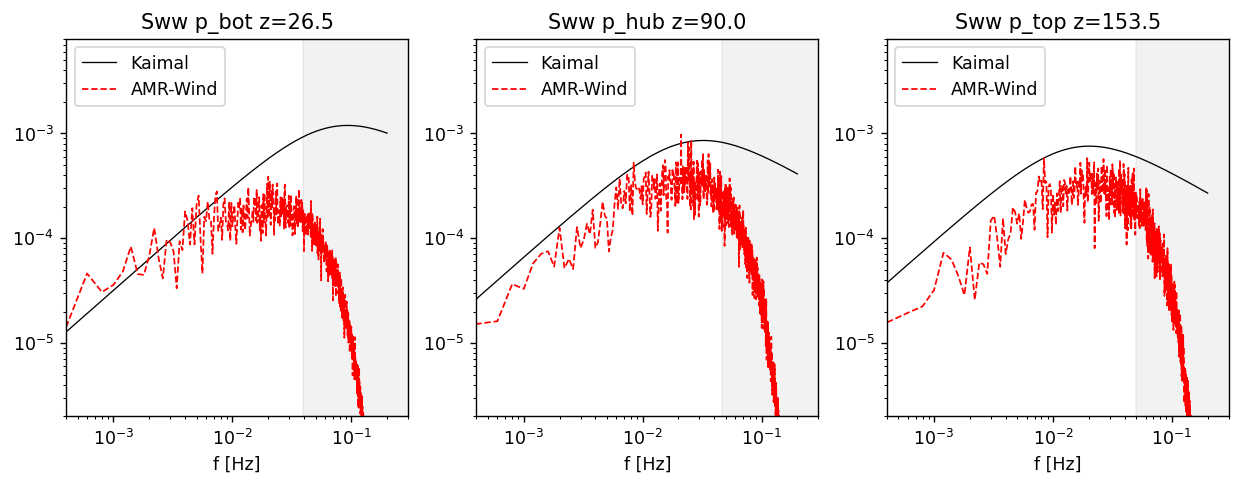

In [15]:
fig, axs = plt.subplots(1,len(grouplist), figsize=(4*len(grouplist),4), dpi=125)
nband=3
dx=10

for igroup, group in enumerate(grouplist):
    name = group['name']
    z    = group['z']
    U    = avgUlong[name]
    f, Sww = windspectra.NarrowToOctaveBand(favg[name], Sww_avg[name], nband)
    ax = axs[igroup]
    ax.loglog(favg[name], utau**2*Sww_Kai[name]/avgUlong[name]**2, '-', color='k', lw=0.75, label='Kaimal')
    ax.loglog(favg[name], favg[name]*Sww_avg[name]/U**2, '--', linewidth=1, color='r', label='AMR-Wind')
    
    ax.set_ylim([2E-6, 8E-3]);
    ax.set_xlim([4E-4, 0.3]);
    ax.set_title('Sww %s z=%0.1f'%(name, z))
    ax.set_xlabel('f [Hz]')
    
    fmax=0.6*U/(8.0*dx)
    ax.axvspan(fmax, 10, alpha=0.1, color='gray')
    ax.legend()